# MSDS 7331 - Lab 3 - Airline Satisfaction Dataset
***
Team - Triston Hudgins, Shijo Joseph, Douglas Yip

#### The dataset chosen is a compilation of airline customer satisfaction surveys.  The goal is to select from one of features (Association Rule Mining, Clustering, or Collaborative Filtering) to build a classifier and analyze its performance in terms of accuracy (precision, recall) and speed) to help us understand the customer sastification. 

Source: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?resource=download&select=test.csv

In [1]:
## Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import scatter
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, layout,XAxis, YAxis, Bar, Line
%matplotlib inline

##Decision tree setup
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

***
### Data Understanding (20 points total)
### [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [2]:
# load the airline satisfaction  dataset

df = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331/main/airline.csv') # read in the csv file
df.head()

#reduced samples set from 100,000 to 30,000 as a few of us had computer performance issues
df = df.sample(n=30000)

#### Check for NAs


In [3]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,4)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 opacity = 0.6,
                 color_discrete_sequence=['red','#808080'],
                 width=800,
                 height=800)
    fig.show()

plot_missingness(df)

print("Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.")

Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.


#### Remove unwanted columns
ID was removed from the dataset as it was used as a unique identified for each passenger

In [4]:
df["GenderNumeric"] = (df["Gender"]=="Male").astype(int)
df["CustomerTypeNumeric"] = (df["Customer Type"]=="Loyal Customer").astype(int)
df["TypeofTravelNumeric"] = (df["Type of Travel"]=="Personal Travel").astype(int)
df["ClassNumeric"] = df["Class"]
df["ClassNumeric"].replace(['Eco', 'Eco Plus', 'Business'], [0, 1, 2], inplace=True)

df["Arrival Delay in Minutes"]= df["Arrival Delay in Minutes"].fillna(0)


dfclean = df.drop(columns=['id'])

dfclean.isnull().sum() #double check on the missing values - 'arrival delay in minutes =310'

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
GenderNumeric                        0
CustomerTypeNumeric                  0
TypeofTravelNumeric      

In [5]:
#Fill in missing values
dfclean["Arrival Delay in Minutes"].fillna(dfclean["Arrival Delay in Minutes"].median(), inplace=True)

In [6]:
dfclean.describe().T

count         mean         std   min  \
Age                                30000.0    39.295100   15.130657   7.0   
Flight Distance                    30000.0  1189.119300  993.511283  31.0   
Inflight wifi service              30000.0     2.726100    1.334943   0.0   
Departure/Arrival time convenient  30000.0     3.073000    1.533085   0.0   
Ease of Online booking             30000.0     2.756267    1.406649   0.0   
Gate location                      30000.0     2.977633    1.284259   1.0   
Food and drink                     30000.0     3.209333    1.324300   0.0   
Online boarding                    30000.0     3.246600    1.344687   0.0   
Seat comfort                       30000.0     3.446033    1.315933   1.0   
Inflight entertainment             30000.0     3.361167    1.332185   0.0   
On-board service                   30000.0     3.375867    1.291271   0.0   
Leg room service                   30000.0     3.337233    1.321905   0.0   
Baggage handling                   30000.0     3.637000    1.181896   1.0   
Checkin service                    30000.0     3.311100    1.260517   1.0   
Inflight service                   30000.0     3.640067    1.179390   0.0   
Cleanliness                        30000.0     3.294367    1.310053   0.0   
Departure Delay in Minutes         30000.0    14.904600   38.393187   0.0   
Arrival Delay in Minutes           30000.0    15.251900   38.829694   0.0   
GenderNumeric                      30000.0     0.496900    0.499999   0.0   
CustomerTypeNumeric                30000.0     0.820233    0.383999   0.0   
TypeofTravelNumeric                30000.0     0.313200    0.463803   0.0   
ClassNumeric                       30000.0     1.029600    0.962092   0.0   

                                     25%    50%      75%     max  
Age                                 27.0   40.0    51.00    85.0  
Flight Distance                    413.0  846.0  1742.00  4983.0  
Inflight wifi service                2.0    3.0     4.00     5.0  
Departure/Arrival time convenient    2.0    3.0     4.00     5.0  
Ease of Online booking               2.0    3.0     4.00     5.0  
Gate location                        2.0    3.0     4.00     5.0  
Food and drink                       2.0    3.0     4.00     5.0  
Online boarding                      2.0    3.0     4.00     5.0  
Seat comfort                         2.0    4.0     5.00     5.0  
Inflight entertainment               2.0    4.0     4.00     5.0  
On-board service                     2.0    4.0     4.00     5.0  
Leg room service                     2.0    4.0     4.00     5.0  
Baggage handling                     3.0    4.0     5.00     5.0  
Checkin service                      3.0    3.0     4.00     5.0  
Inflight service                     3.0    4.0     5.00     5.0  
Cleanliness                          2.0    3.0     4.00     5.0  
Departure Delay in Minutes           0.0    0.0    12.25  1017.0  
Arrival Delay in Minutes             0.0    0.0    13.00  1011.0  
GenderNumeric                        0.0    0.0     1.00     1.0  
CustomerTypeNumeric                  1.0    1.0     1.00     1.0  
TypeofTravelNumeric                  0.0    0.0     1.00     1.0  
ClassNumeric                         0.0    1.0     2.00     2.0

In [7]:
dfclean.corr()

Age  Flight Distance  \
Age                                1.000000         0.094015   
Flight Distance                    0.094015         1.000000   
Inflight wifi service              0.011428         0.010442   
Departure/Arrival time convenient  0.037333        -0.019207   
Ease of Online booking             0.017502         0.064256   
Gate location                     -0.008749         0.004323   
Food and drink                     0.027228         0.058369   
Online boarding                    0.210173         0.211081   
Seat comfort                       0.165264         0.150961   
Inflight entertainment             0.079834         0.126398   
On-board service                   0.057353         0.112380   
Leg room service                   0.044061         0.138323   
Baggage handling                  -0.048654         0.073101   
Checkin service                    0.035286         0.068978   
Inflight service                  -0.051334         0.067278   
Cleanliness                        0.054715         0.096227   
Departure Delay in Minutes        -0.012164        -0.009315   
Arrival Delay in Minutes          -0.016293        -0.013277   
GenderNumeric                      0.006887         0.010266   
CustomerTypeNumeric                0.270779         0.221345   
TypeofTravelNumeric               -0.051894        -0.262079   
ClassNumeric                       0.140138         0.440754   

                                   Inflight wifi service  \
Age                                             0.011428   
Flight Distance                                 0.010442   
Inflight wifi service                           1.000000   
Departure/Arrival time convenient               0.348020   
Ease of Online booking                          0.717483   
Gate location                                   0.335155   
Food and drink                                  0.136706   
Online boarding                                 0.455785   
Seat comfort                                    0.116588   
Inflight entertainment                          0.209967   
On-board service                                0.124702   
Leg room service                                0.159923   
Baggage handling                                0.124066   
Checkin service                                 0.045490   
Inflight service                                0.106676   
Cleanliness                                     0.131516   
Departure Delay in Minutes                     -0.016934   
Arrival Delay in Minutes                       -0.019929   
GenderNumeric                                   0.006743   
CustomerTypeNumeric                             0.009810   
TypeofTravelNumeric                            -0.107648   
ClassNumeric                                    0.036316   

                                   Departure/Arrival time convenient  \
Age                                                         0.037333   
Flight Distance                                            -0.019207   
Inflight wifi service                                       0.348020   
Departure/Arrival time convenient                           1.000000   
Ease of Online booking                                      0.439455   
Gate location                                               0.448900   
Food and drink                                              0.008169   
Online boarding                                             0.075431   
Seat comfort                                                0.010991   
Inflight entertainment                                     -0.004047   
On-board service                                            0.067672   
Leg room service                                            0.011587   
Baggage handling                                            0.067351   
Checkin service                                             0.091124   
Inflight service                                            0.066817   
Cleanliness                       

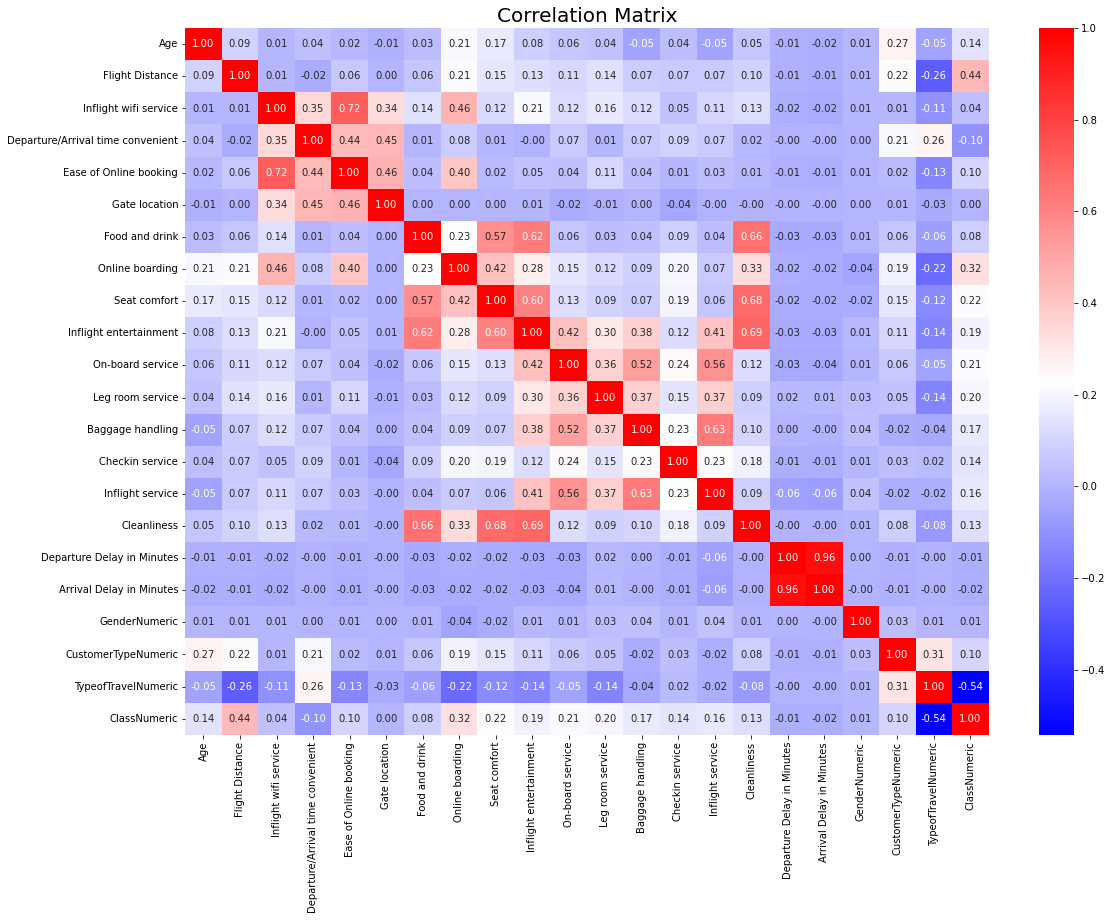

In [8]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(dfclean.corr(), annot=True, fmt=".2f", ax=ax, cmap="bwr")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

Very strong correlations (values from 0.8 to 1 or -0.8 to -1.0)
Strong correlations (values from 0.6 to 0.8 or -0.6 to -0.8)
Moderate correlations (values from 0.4 to 0.6 or -0.4 to -0.6) 

#### Check distribution of the data

C:\Users\thud1\anaconda3\envs\ML7331\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



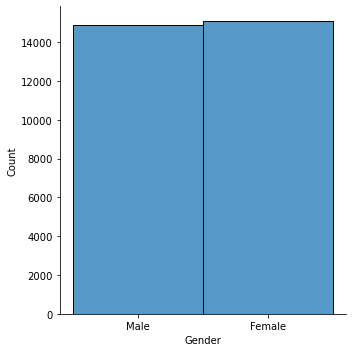

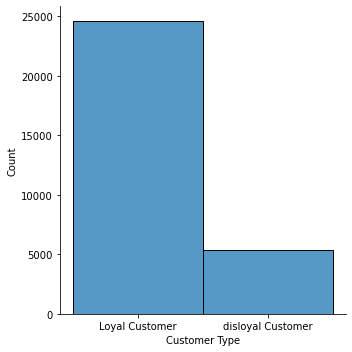

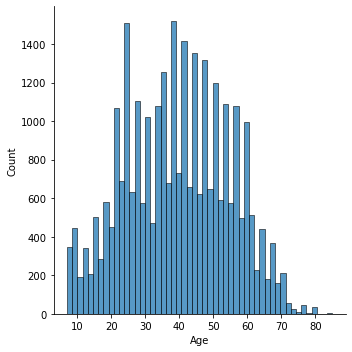

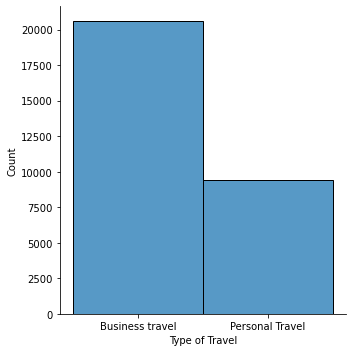

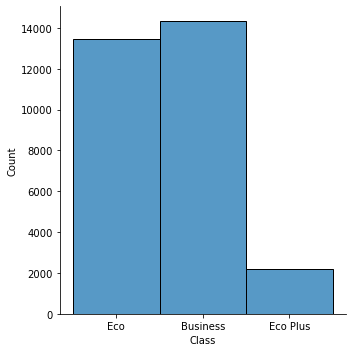

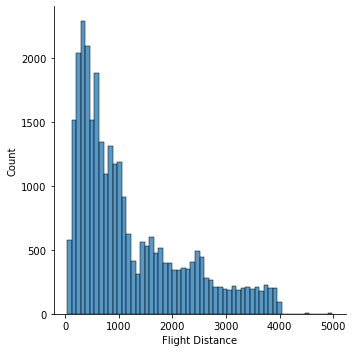

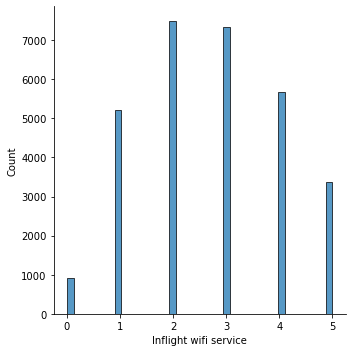

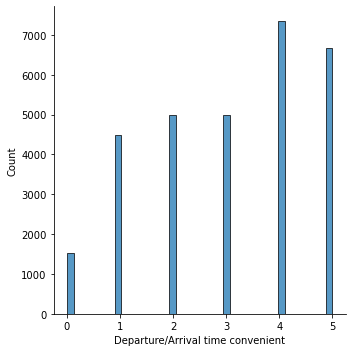

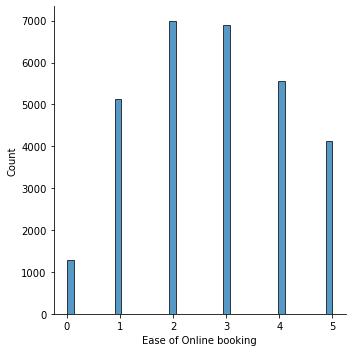

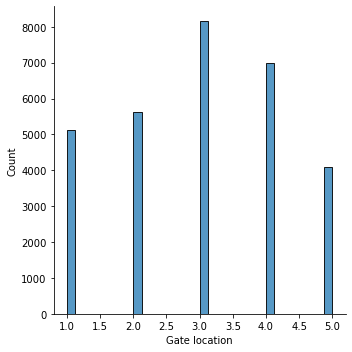

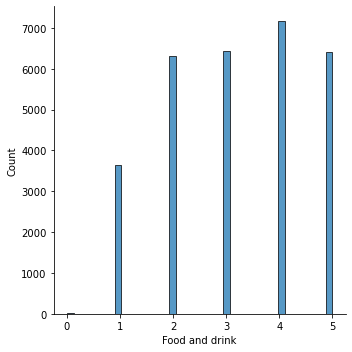

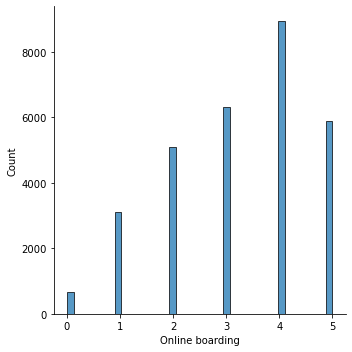

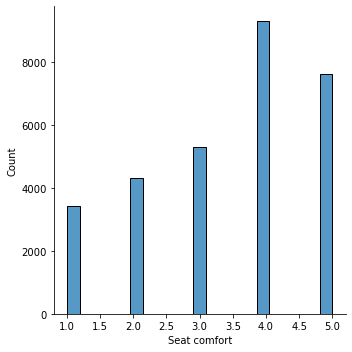

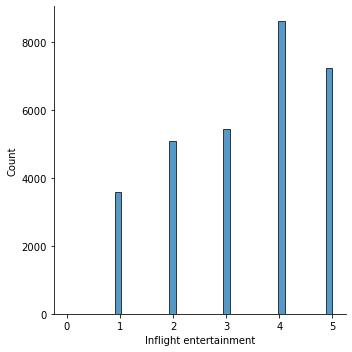

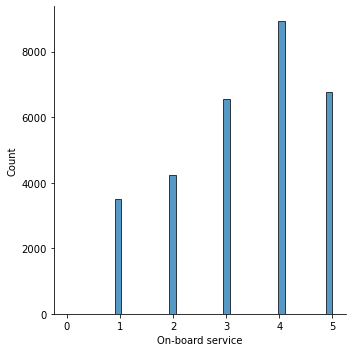

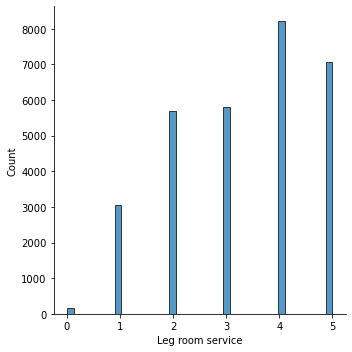

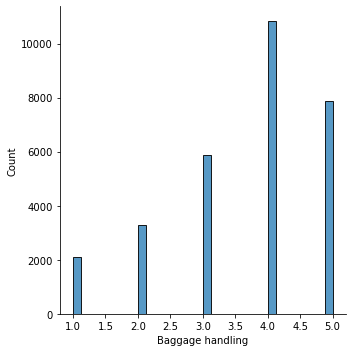

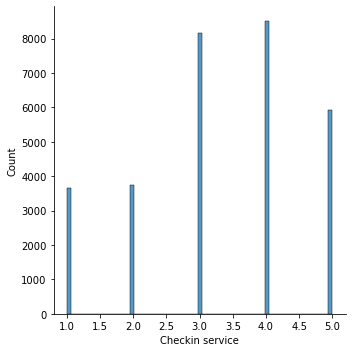

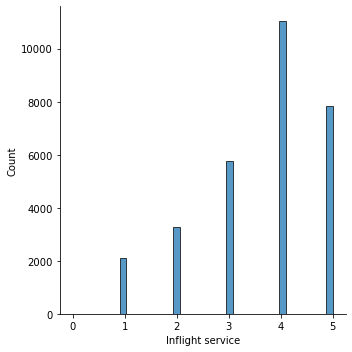

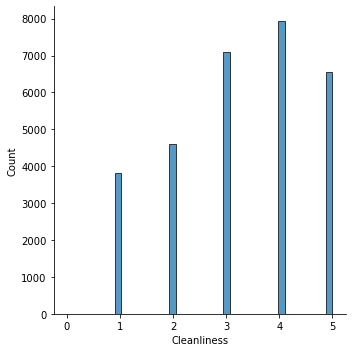

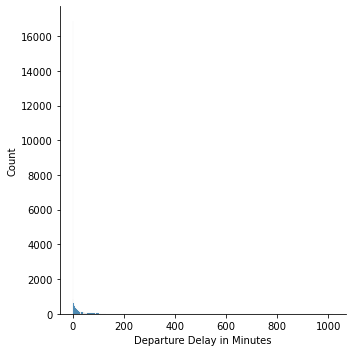

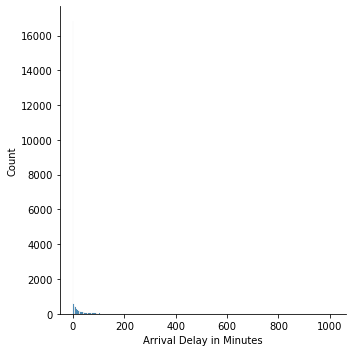

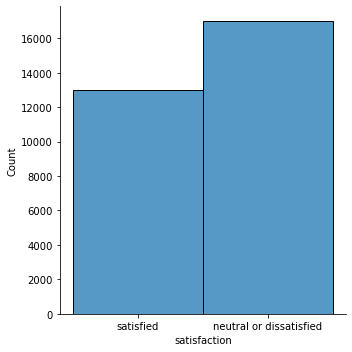

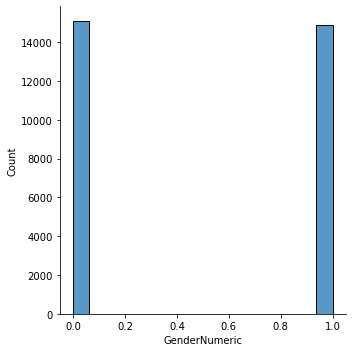

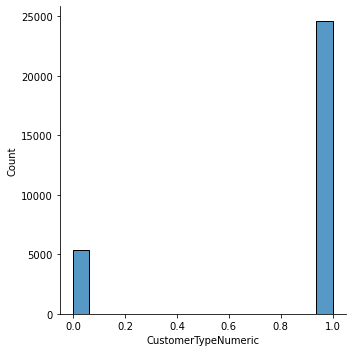

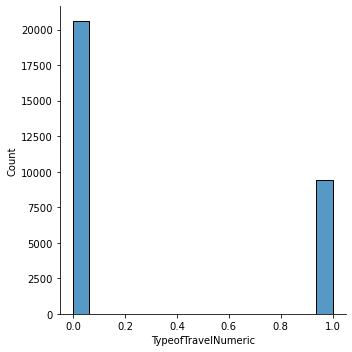

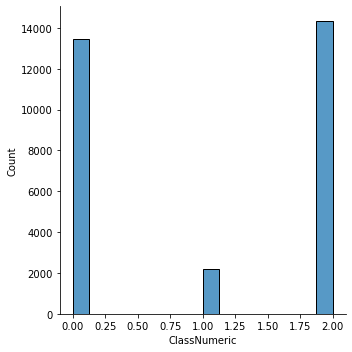

In [9]:
##distribution of the data

for column in dfclean:
    
    sns.displot(x=column, data=dfclean)

In [10]:
print (dfclean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 31639 to 54291
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             30000 non-null  object 
 1   Customer Type                      30000 non-null  object 
 2   Age                                30000 non-null  int64  
 3   Type of Travel                     30000 non-null  object 
 4   Class                              30000 non-null  object 
 5   Flight Distance                    30000 non-null  int64  
 6   Inflight wifi service              30000 non-null  int64  
 7   Departure/Arrival time convenient  30000 non-null  int64  
 8   Ease of Online booking             30000 non-null  int64  
 9   Gate location                      30000 non-null  int64  
 10  Food and drink                     30000 non-null  int64  
 11  Online boarding                    30000 non-null 

#### Summary of values to be used in classification modeling
A total of +100,000 passenger results are recorded in this data set.
We have a combination of categorical, ordinal and continous variable in this dataset.

- __Gender:__- Gender of the passengers (Female, Male) - Categorical Variable
- __Customer Type:__- The customer type (Loyal customer, disloyal customer) - Categorical Variable
- __Age:__- The actual age of the passengers - Continous Variable
- __Type of Travel:__- Purpose of the flight of the passengers (Personal Travel, Business Travel) - Categorical Variable
- __Class:__- Travel class in the plane of the passengers (Business, Eco, Eco Plus) - Categorical Variable
- __Flight distance:__- The flight distance of this journey - Continous Variable
- __Inflight wifi service:__- Satisfaction level of the inflight wifi service (0:Not Applicable;1-5) - Categorical Variable
- __Departure/Arrival time convenient:__- Satisfaction level of Departure/Arrival time convenient - Categorical Variable
- __Ease of Online booking:__- Satisfaction level of online booking - Categorical Variable
- __Gate location:__- Satisfaction level of Gate location - Categorical Variable
- __Food and drink:__- Satisfaction level of Food and drink - Categorical Variable
- __Online boarding:__- Satisfaction level of online boarding - Categorical Variable
- __Seat comfort:__- Satisfaction level of Seat comfort - Categorical Variable
- __Inflight entertainment:__- Satisfaction level of inflight entertainment - Categorical Variable
- __On-board service:__- Satisfaction level of On-board service - Categorical Variable
- __Leg room service:__- Satisfaction level of Leg room service - Categorical Variable
- __Baggage handling:__- Satisfaction level of baggage handling - Categorical Variable
- __Check-in service:__- Satisfaction level of Check-in service - Categorical Variable
- __Inflight service:__- Satisfaction level of inflight service - Categorical Variable
- __Cleanliness:__- Satisfaction level of Cleanliness - Categorical Variable
- __Departure Delay in Minutes:__- Minutes delayed when departure - Continous Variable
- __Arrival Delay in Minutes:__- Minutes delayed when Arrival - Continous Variable
- __Satisfaction:__- Airline satisfaction level(Satisfaction, neutral or dissatisfaction) - Categorical Variable

*** 
### [10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

##### Differences between avg score between business and economy - two-sided t test
##### Random BS Graphs
##### ANOVA on Age

In [11]:
 #Add Totals Column - index(6:19)
dfclean['Total']=dfclean.iloc[:,6:19].sum(axis=1)

#Add Age Groups
dfclean['Age Group'] = pd.cut(dfclean['Age'], bins = [0,17,35,65,90], labels=["Adolescent", "Young Adult", "Middle Age", "Senior"], right=True)

#Add Distance Groups
dfclean['Distance Group'] = pd.cut(dfclean['Flight Distance'], bins = [0,500,1000,2500,5000], labels=["Short", "Moderate", "Long", "Extra Long"], right=True)

dfclean.head(n=50)

Gender      Customer Type  Age   Type of Travel     Class  \
31639     Male     Loyal Customer   56  Business travel       Eco   
36459   Female     Loyal Customer   36  Personal Travel       Eco   
10585     Male     Loyal Customer   28  Business travel  Business   
74907     Male     Loyal Customer   59  Business travel  Business   
8176      Male  disloyal Customer   40  Business travel  Business   
57449     Male     Loyal Customer   17  Personal Travel       Eco   
11276   Female  disloyal Customer   33  Business travel  Business   
48860   Female     Loyal Customer   22  Business travel  Business   
28699     Male  disloyal Customer   32  Business travel  Business   
63743   Female     Loyal Customer   53  Business travel  Business   
86338   Female     Loyal Customer   45  Business travel       Eco   
1644      Male     Loyal Customer   16  Personal Travel       Eco   
21412   Female     Loyal Customer   53  Business travel  Business   
69375   Female     Loyal Customer   54  Business travel  Business   
24013   Female     Loyal Customer   53  Personal Travel       Eco   
82801   Female     Loyal Customer   45  Business travel       Eco   
96750   Female     Loyal Customer   37  Business travel       Eco   
15501   Female     Loyal Customer   30  Personal Travel       Eco   
68911     Male     Loyal Customer   53  Business travel  Business   
38927   Female  disloyal Customer   61  Business travel       Eco   
182     Female     Loyal Customer   47  Personal Travel       Eco   
90192   Female     Loyal Customer   24  Personal Travel       Eco   
67716   Female     Loyal Customer   55  Business travel  Business   
71021     Male     Loyal Customer   53  Business travel       Eco   
99828   Female     Loyal Customer   45  Business travel  Business   
30956     Male     Loyal Customer   65  Personal Travel  Eco Plus   
13853   Female  disloyal Customer   54  Business travel  Eco Plus   
68915     Male     Loyal Customer   58  Business travel  Business   
65205   Female  disloyal Customer   22  Business travel  Business   
49404     Male     Loyal Customer   69  Business travel  Business   
32232     Male     Loyal Customer   52  Personal Travel       Eco   
62642   Female     Loyal Customer   33  Personal Travel       Eco   
13606   Female     Loyal Customer    8  Personal Travel  Eco Plus   
66943   Female  disloyal Customer   27  Business travel  Business   
26222     Male  disloyal Customer   36  Business travel       Eco   
4355    Female  disloyal Customer   29  Business travel  Business   
82990     Male     Loyal Customer   13  Personal Travel  Business   
101285    Male     Loyal Customer   25  Personal Travel       Eco   
71973     Male  disloyal Customer   32  Business travel  Business   
3508    Female  disloyal Customer   25  Business travel  Business   
37349   Female  disloyal Customer   27  Business travel       Eco   
50494   Female     Loyal Customer   20  Personal Travel       Eco   
77647     Male     Loyal Customer   51  Business travel  Business   
13292     Male     Loyal Customer   55  Business travel  Business   
42498     Male     Loyal Customer   50  Business travel       Eco   
42612     Male     Loyal Customer   58  Business travel  Eco Plus   
90374     Male     Loyal Customer   37  Business travel  Business   
27141     Male     Loyal Customer   55  Business travel  Business   
90361     Male  disloyal Customer   22  Business travel       Eco   
56728   Female     Loyal Customer   42  Personal Travel       Eco   

        Flight Distance  Inflight wifi service  \
31639               331                      4   
36459               590                      4   
10585              3326                      2   
74907               761                      4   
8176                287                      4   
57449               449                      4   
11276               200                      4   
48860              3119                      1   
28699               216               

In [12]:
#Plotly Histogram - Age
px.histogram(dfclean['Age'], x= "Age",
             title = 'Age Distribution',
             )

In [13]:
#Plotly Histogram - Flight Distance
px.histogram(dfclean['Flight Distance'], x= "Flight Distance",
             title = 'Flight Distance Distribution',
             )

In [14]:
#Plotly Histogram - Departure Delay in Minutes
px.histogram(dfclean['Departure Delay in Minutes'], x= "Departure Delay in Minutes",
             title = 'Departure Delay Distribution',
             nbins = 50,
             )

In [15]:
#Plotly Histogram - Arrival Delay in Minutes
px.histogram(dfclean['Arrival Delay in Minutes'], x= "Arrival Delay in Minutes",
             title = 'Arrival Delay Distribution',
             nbins = 50,
             )

In [16]:
px.box(dfclean,
       x="Class", y="Age", 
       color="Class",
       title = "Box Plot of Age by Class")

In [17]:
px.box(dfclean,
       x="Distance Group", y="Total", 
       color="Distance Group",
       title = "Box Plot of Age by Class")

***
### Modeling and Evaluation (50 points total) Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. 



### Deployment (10 points total)
- Be critical of your performance and tell the reader how you current model might be usable by
other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
- How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it)?
- How would your deploy your model for interested parties?
- What other data should be collected?
- How often would the model need to be updated, etc.?

### Exceptional Work (10 points total)
You have free reign to provide additional analyses or combine analyses